# nearby galaxy catalog: 
<11 Mpc

https://ui.adsabs.harvard.edu/abs/2013AJ....145..101K/abstract
http://ciber0.rit.edu/~ciber/logbook/20190530_stackerr/

In [1]:
from clusters import *

# Abell cluster cats
https://heasarc.gsfc.nasa.gov/db-perl/W3Browse/w3table.pl?tablehead=name%3Dabell&Action=More+Options
https://ui.adsabs.harvard.edu/abs/1958ApJS....3..211A/abstract

In [2]:
df = clusters(1,4).abell_cat()

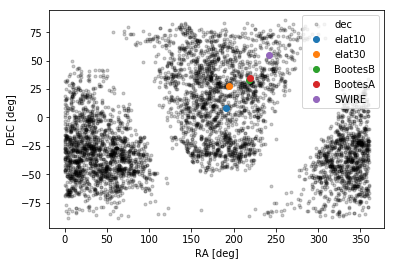

In [3]:
plt.plot(df['ra'], df['dec'], 'k.', alpha=0.2)
for ifield in [4,5,6,7,8]:
    ra_cent, dec_cent = field_center_dict[ifield]
    plt.plot(ra_cent, dec_cent, 'o', label=fieldnamedict[ifield])
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')
plt.legend()

# Cluster catalog
z = 0.05 (~ 200 Mpc) - 0.42

https://ui.adsabs.harvard.edu/abs/2012ApJS..199...34W/abstract

Fig.6 completeness function

elat10 ABELL1601  70
elat30 ABELL1641  79
elat30 ABELL1619  55
elat30 ABELL1628  57
elat30 ABELL1632  80
SWIRE ABELL2168  66
SWIRE ABELL2166  51


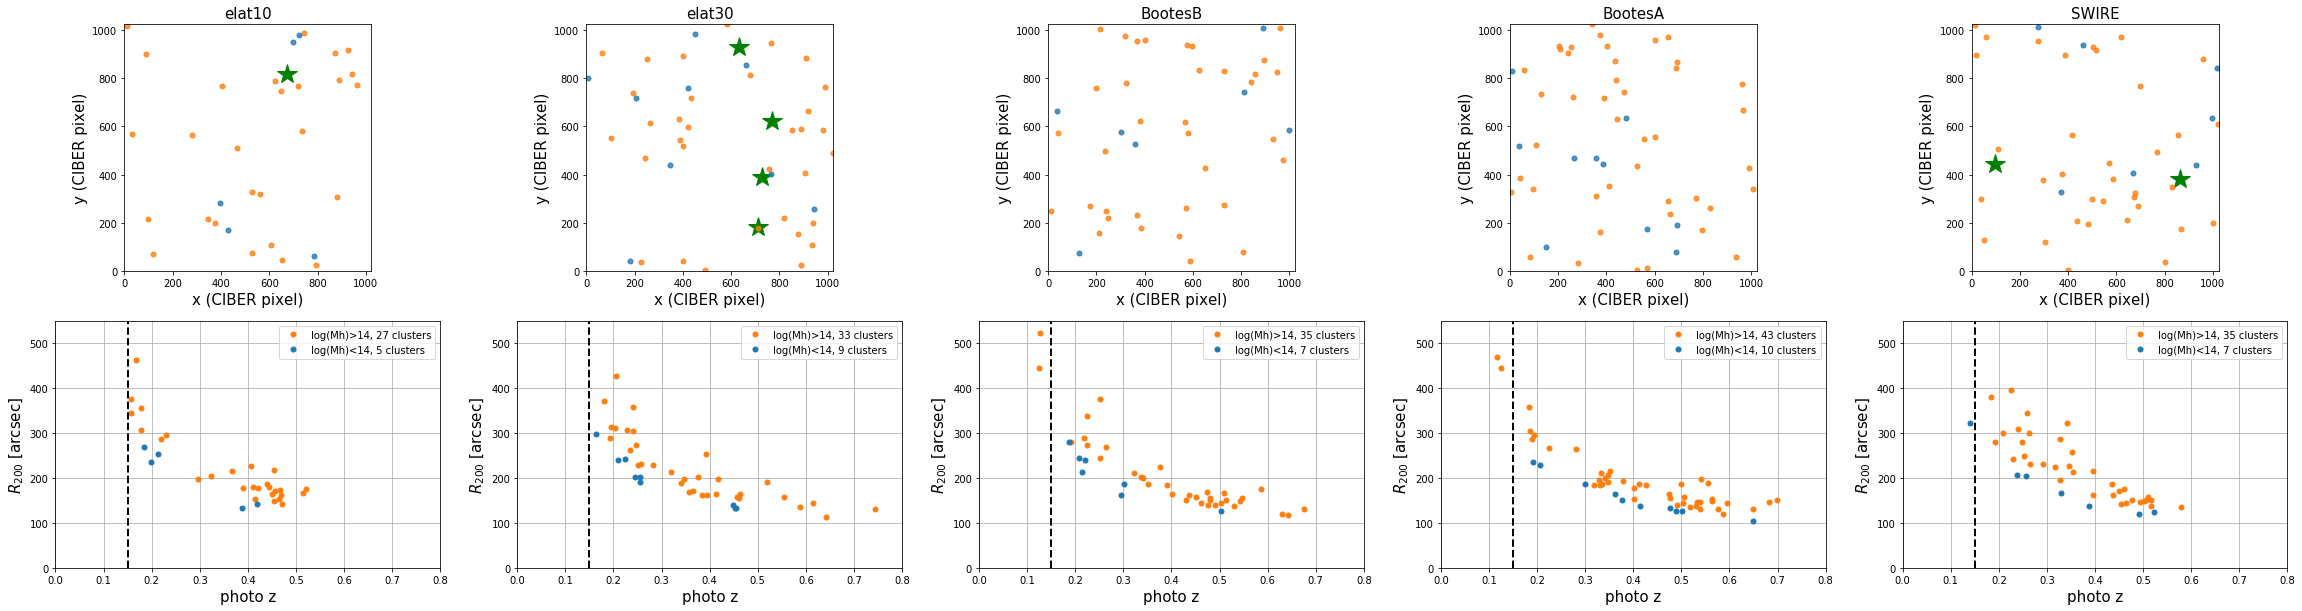

In [4]:
fig, ax = plt.subplots(2,5,figsize=(40,10))
for i,ifield in enumerate([4,5,6,7,8]): 
    dfa = clusters(1,ifield).abell_src()
    dfc = clusters(1,ifield, lnMhrange=(0, np.inf)).sdss_src()
    
    sp14g = np.where(dfc['lmhalo']>=14)[0]
    sp14l = np.where(dfc['lmhalo']<14)[0]
    Ng, Nl = len(sp14g), len(sp14l)
    
    if len(dfa)>0:
        for name,count in zip(dfa['name'],dfa['_count']):
            print(fieldnamedict[ifield], name, count)
        
    ax[0][i].plot(dfa['x1'], dfa['y1'],'g*', markersize=20)
    ax[0][i].plot(dfc['x1'].iloc[sp14g],dfc['y1'].iloc[sp14g], 'C1.',markersize=10,alpha=0.8)
    ax[0][i].plot(dfc['x1'].iloc[sp14l],dfc['y1'].iloc[sp14l], 'C0.',markersize=10,alpha=0.8)

    ax[0][i].set_title(fieldnamedict[ifield], fontsize = 15)
    ax[0][i].set_xlabel('x (CIBER pixel)', fontsize = 15)
    ax[0][i].set_ylabel('y (CIBER pixel)', fontsize = 15)
    ax[0][i].set_xlim([-0.5, 1023.5])
    ax[0][i].set_ylim([-0.5, 1023.5])
    ax[0][i].set_aspect('equal')
    
    ax[1][i].plot(dfc['zph'].iloc[sp14g],dfc['r200_arcsec'].iloc[sp14g], 'C1.',
                  markersize = 10, label='log(Mh)>14, %d clusters'%Ng)
    ax[1][i].plot(dfc['zph'].iloc[sp14l],dfc['r200_arcsec'].iloc[sp14l], 'C0.',
                  markersize = 10, label='log(Mh)<14, %d clusters'%Nl)
    ax[1][i].set_ylabel('y (CIBER pixel)', fontsize = 15)
    ax[1][i].set_xlabel('photo z', fontsize = 15)
    ax[1][i].set_ylabel('$R_{200}$ [arcsec]', fontsize = 15)
    ax[1][i].axvline(0.15, c='k', lw=2, ls='--')
    ax[1][i].set_xlim([0,0.8])
    ax[1][i].set_ylim([0,550])
    ax[1][i].legend()
    ax[1][i].grid()
# fig.savefig('/Users/ytcheng/Desktop/clus_cat.png',
#              dpi = 150, bbox_inches='tight')

In [17]:
inst = 1
ifield = 8

dfa = clusters(inst, ifield).abell_src()
dfcmh = clusters(inst, ifield, lnMhrange=(14, np.inf)).sdss_src()
dfcz = clusters(inst, ifield, zrange=(0, 0.15)).sdss_src()
maskmh = clusters(inst, ifield, lnMhrange=(14, np.inf)).cluster_mask()
maskz = clusters(inst, ifield, zrange=(0, 0.15)).cluster_mask()

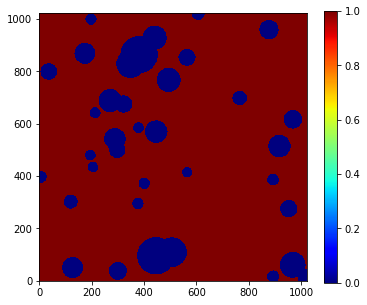

In [18]:
imageclip(maskmh*maskz)

# 2MASS Extended
https://iopscience.iop.org/article/10.1086/301330/pdf

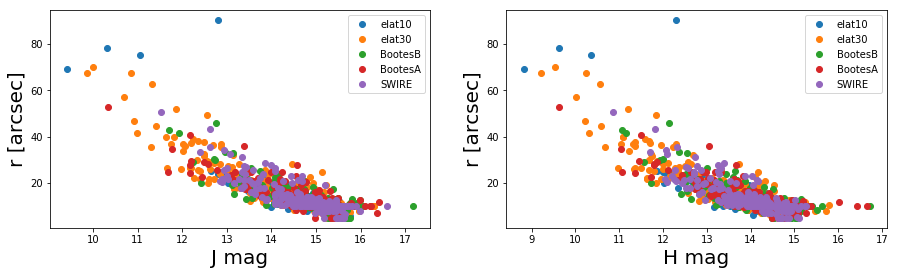

In [55]:
inst = 1
catcoorddir = mypaths['ciberdir'] + 'doc/20170617_Stacking/maps/2masscats/XSC/'

fig, ax = plt.subplots(1,2,figsize=(15,4))
for i,field in enumerate(['elat10','elat30','BootesB','BootesA','SWIRE']): 
    fname = catcoorddir+ field + '.tbl'
    data = np.loadtxt(fname, skiprows=38, usecols=(0,1,2,3,5,7))
    df = pd.DataFrame(data, columns=['ra', 'dec', 'r_ext', 'j', 'h', 'k'])
    df = cat_add_xy(field, df)
    df = df[(df['x1']>-0.5) & (df['x1']<1023.5) & (df['y1']>-0.5) & (df['y1']<1023.5)]
    ax[0].plot(df['j'],df['r_ext'],'o',label=field)
    ax[1].plot(df['h'],df['r_ext'],'o',label=field)

ax[0].set_xlabel('J mag', fontsize = 20)
ax[0].set_ylabel('r [arcsec]', fontsize = 20)
ax[1].set_xlabel('H mag', fontsize = 20)
ax[1].set_ylabel('r [arcsec]', fontsize = 20)

ax[0].legend()
ax[1].legend()